In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tensorflow.keras import layers
from xgboost import XGBRegressor
from yellowbrick.model_selection import ValidationCurve

In [3]:
# data set https://www.kaggle.com/datasets/samanemami/renewable-energy-and-weather-conditions
df = pd.read_csv('/kaggle/input/renewable-energy-and-weather-conditions/solar_weather.csv', parse_dates=['Time'])
display(df)

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022-08-31 16:45:00,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8
196772,2022-08-31 17:00:00,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8
196773,2022-08-31 17:15:00,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8
196774,2022-08-31 17:30:00,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,1,825,825,1.00,3,17,8


In [4]:
print(df.columns)

Index(['Time', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength', 'weather_type',
       'hour', 'month'],
      dtype='object')


In [5]:
nulls_df = pd.DataFrame(df.isnull().sum(), columns = ['Null amount'])

display(nulls_df.T)

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
Null amount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
display(df.describe())

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
count,196776,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000
mean,2019-10-29 22:44:12.085620992,573.008228,32.596538,9.790521,1015.292780,79.810566,3.937746,0.066035,0.007148,65.974387,0.519962,211.721094,748.644347,0.265187,3.198398,11.498902,6.298329
min,2017-01-01 00:00:00,0.000000,0.000000,-16.600000,977.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,450.000000,0.000000,1.000000,0.000000,1.000000
25%,2018-06-02 10:26:15,0.000000,0.000000,3.600000,1010.000000,70.000000,2.600000,0.000000,0.000000,34.000000,0.000000,0.000000,570.000000,0.000000,2.000000,5.000000,3.000000
50%,2019-10-28 20:52:30,0.000000,1.600000,9.300000,1016.000000,84.000000,3.700000,0.000000,0.000000,82.000000,1.000000,30.000000,765.000000,0.050000,4.000000,11.000000,6.000000
75%,2021-03-24 07:18:45,577.000000,46.800000,15.700000,1021.000000,92.000000,5.000000,0.000000,0.000000,100.000000,1.000000,390.000000,930.000000,0.530000,4.000000,17.000000,9.000000
max,2022-08-31 17:45:00,5020.000000,229.200000,35.800000,1047.000000,100.000000,14.300000,8.090000,2.820000,100.000000,1.000000,1020.000000,1020.000000,1.000000,5.000000,23.000000,12.000000
std,NaN,1044.824047,52.172018,7.995428,9.585773,15.604459,1.821694,0.278913,0.069710,36.628593,0.499603,273.902186,194.870208,0.329023,1.289939,6.921887,3.376066


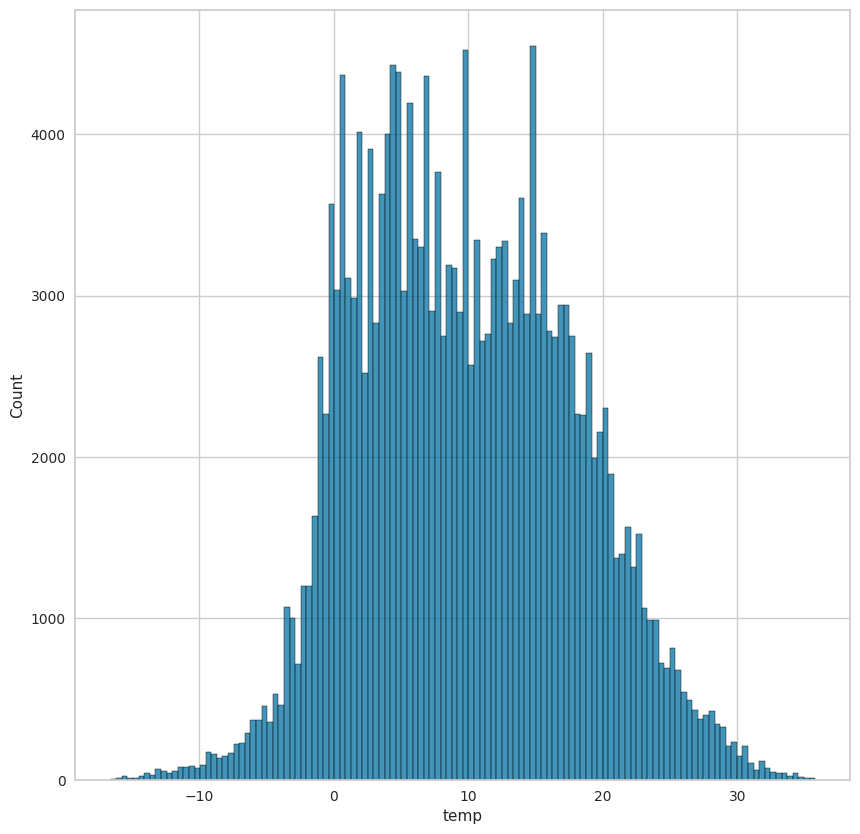

In [7]:
fig, ax = plt.subplots(figsize = (10,10))
sns.histplot(data = df['temp'], ax = ax)
plt.show()

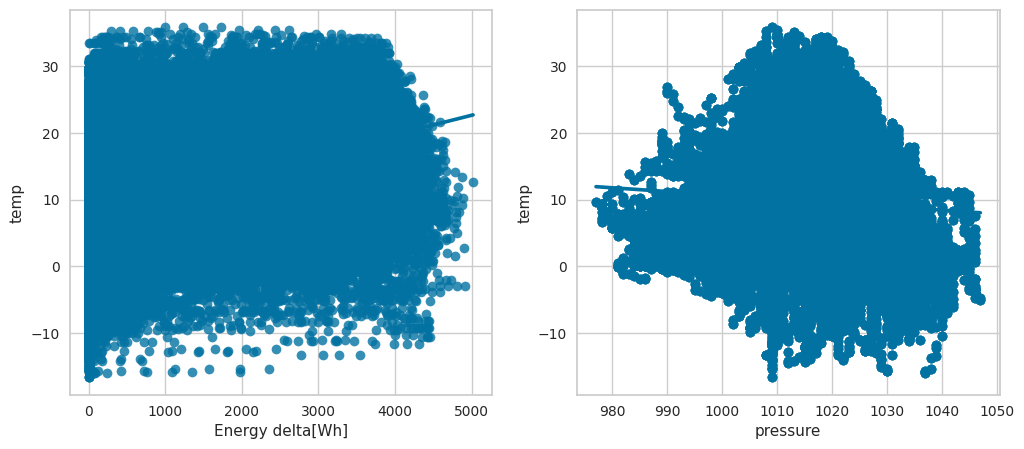

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

sns.regplot(data = df, 
            x = 'Energy delta[Wh]', 
            y = 'temp', 
            ax = axes[0]
           )

sns.regplot(data = df, 
           x = 'pressure', 
           y = 'temp', 
           ax = axes[1]
          )

plt.show()

In [9]:
numeric = df.drop(columns = ['isSun','weather_type'])

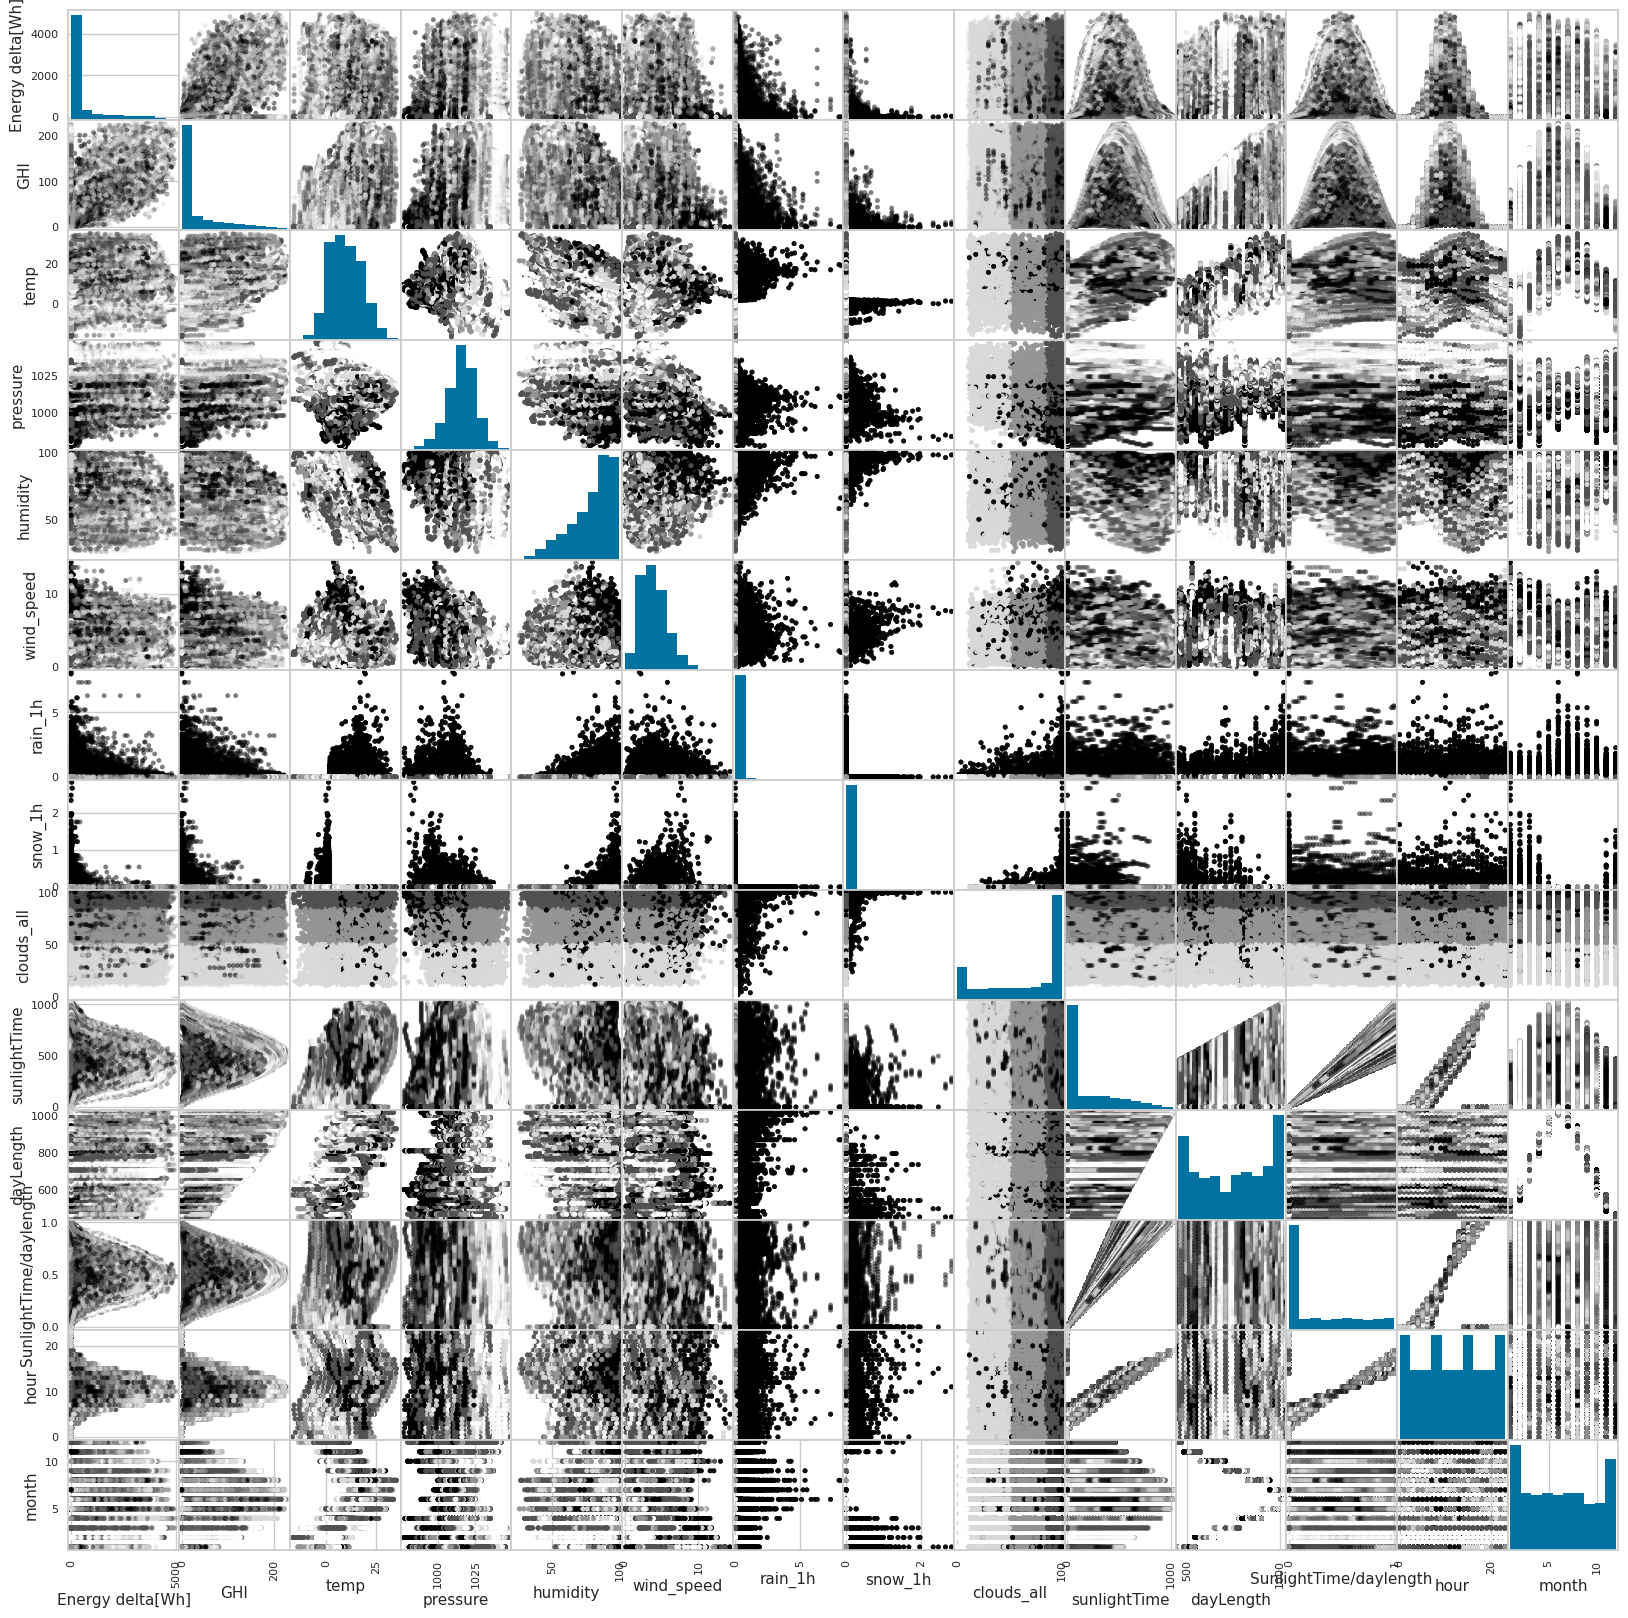

In [10]:
pd.plotting.scatter_matrix(numeric, c = df['weather_type'], figsize = (20, 20))
plt.show()

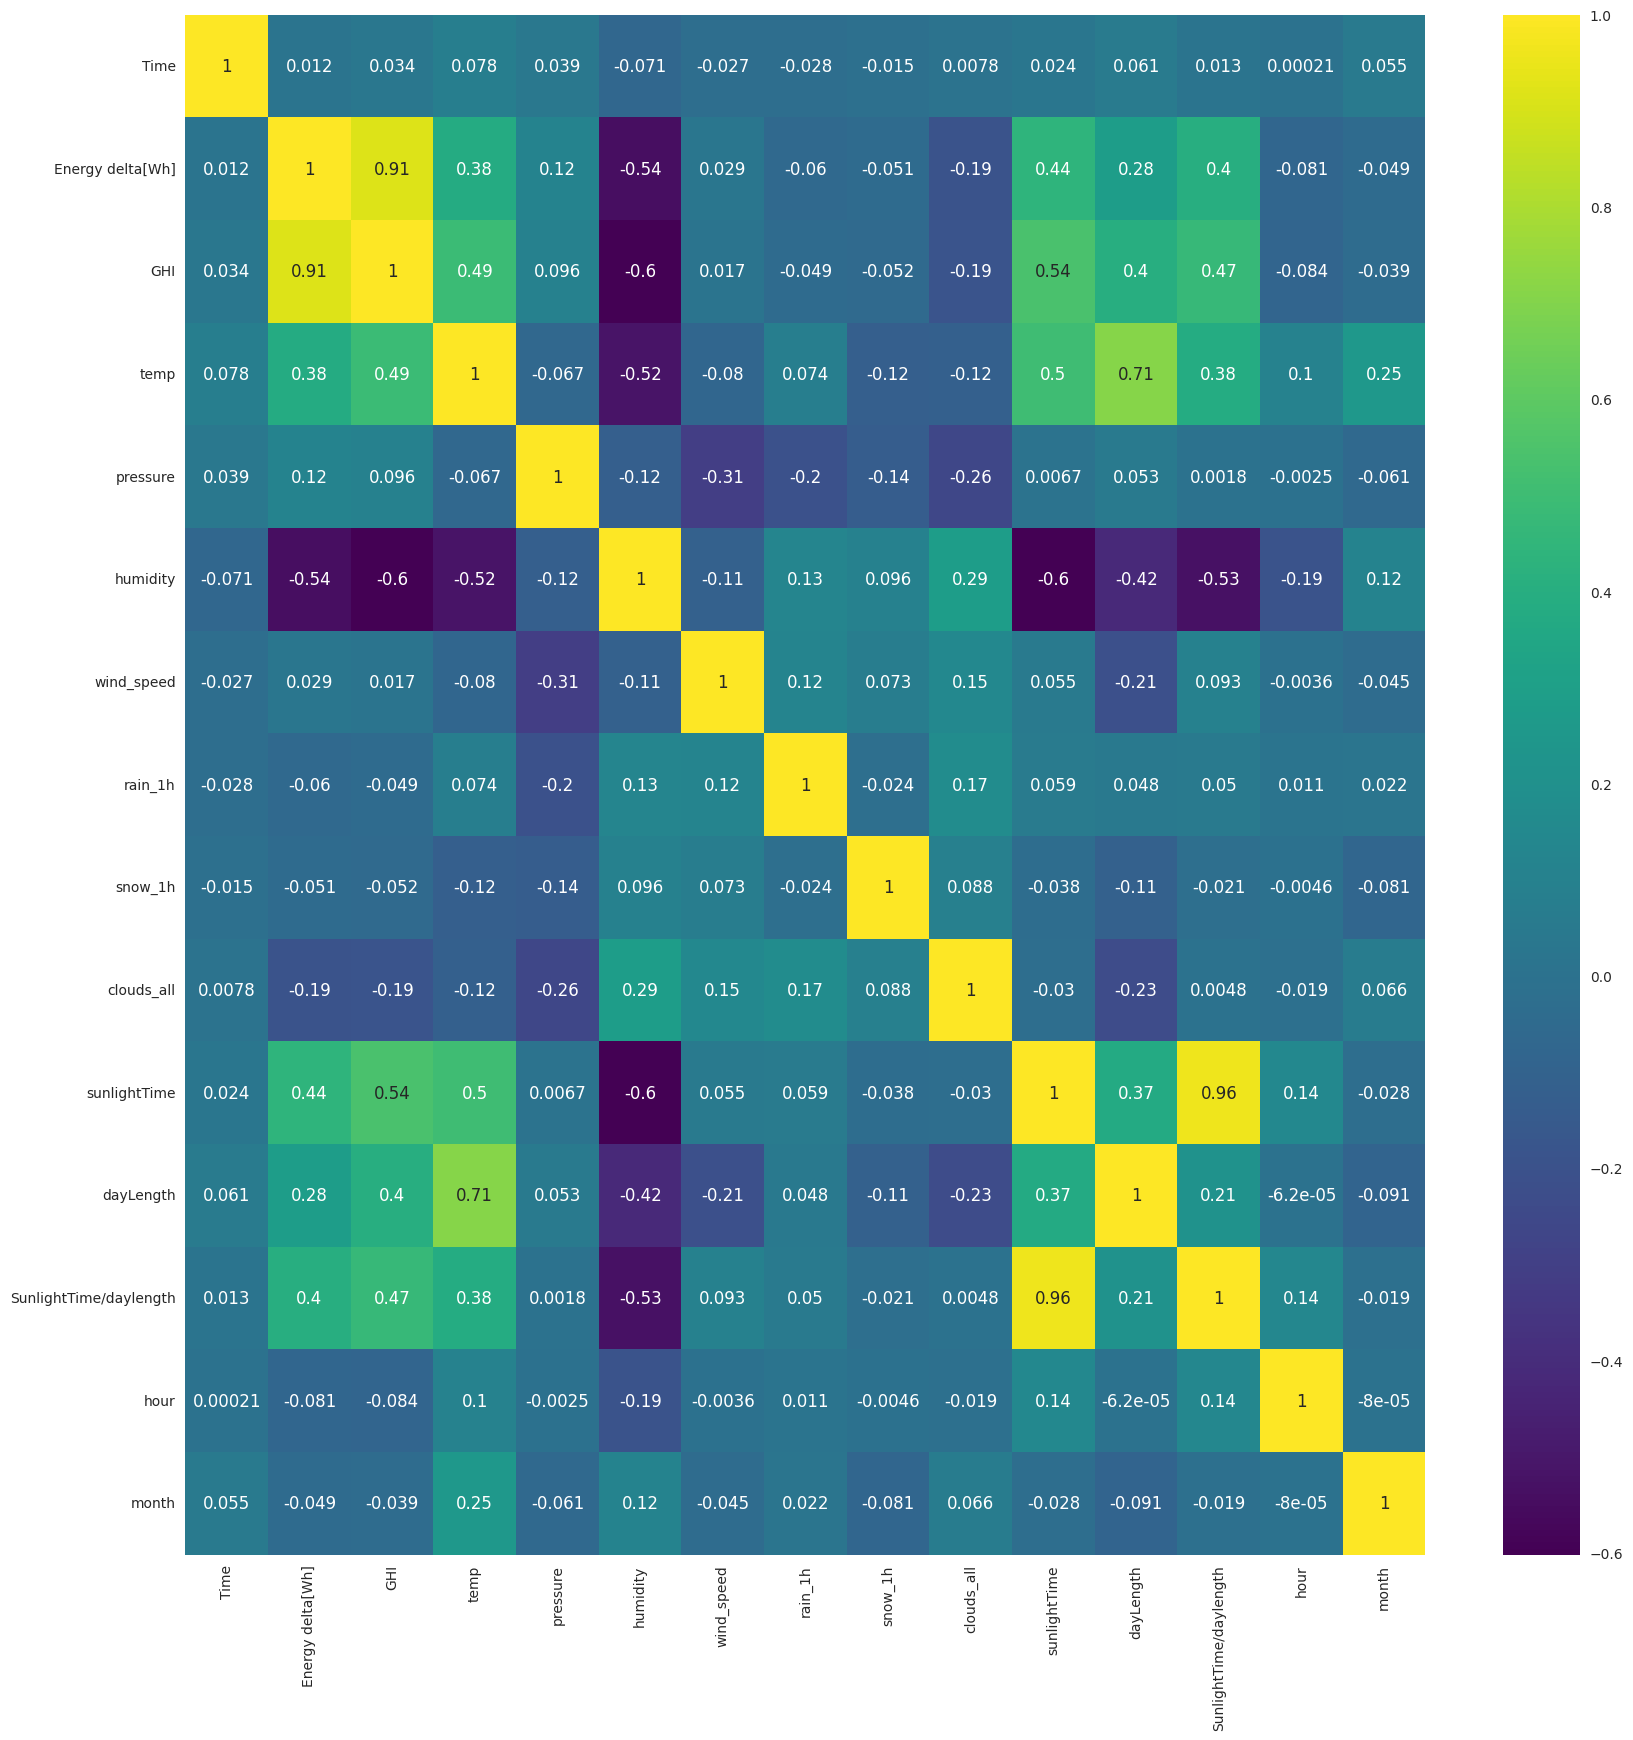

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(numeric.corr(), annot = True, cmap = 'viridis')
plt.show()

In [12]:
X = df.drop(columns=['temp','Time'])
y = df['temp']

In [13]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    test_size = 0.6, 
                                                    random_state = 42
                                                   )
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((78710, 15), (118066, 15), (78710,), (118066,))

In [78]:
rforest = RandomForestRegressor(n_estimators = 150, 
                                n_jobs = 2, 
                                max_leaf_nodes = 704,
                                random_state = 42
                               )
rforest.fit(train_X, train_y)

RandomForestRegressor(max_leaf_nodes=704, n_estimators=150, n_jobs=2,
                      random_state=42)

In [79]:
print(f"Random forest train r2 score = {rforest.score(train_X, train_y)}")
print(f"Random forest test r2 score = {rforest.score(test_X, test_y)}")

Random forest train r2 score = 0.9161942686449647
Random forest test r2 score = 0.905927674414316


In [80]:
forest_scores = cross_val_score(RandomForestRegressor(n_estimators = 150, 
                                                      max_leaf_nodes = 704, 
                                                      random_state = 42
                                                     ), 
                                X, y, cv = 5, n_jobs = 4
                               )

In [81]:
print(f"Cross val scores for random forest = {forest_scores}")
print(f"Mean cross val scores = {forest_scores.mean()}")
print(f"Cross val scores standard deviation = {forest_scores.std()}")

Cross val scores for random forest = [0.79659508 0.74173898 0.73978985 0.81680712 0.81399249]
Mean cross val scores = 0.7817847038763059
Cross val scores standard deviation = 0.03420668371038444


In [82]:
rlinear = Pipeline([('scaler', StandardScaler()), 
                    ('regressor', LinearRegression())
                   ])
rlinear.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [83]:
print(f"Linear regression train r2 score = {rlinear.score(train_X, train_y)}")
print(f"Linear regression test r2 score = {rlinear.score(test_X, test_y)}")

Linear regression train r2 score = 0.7189484720004629
Linear regression test r2 score = 0.7189994054200199


In [84]:
linear_scores = cross_val_score(Pipeline([('scaler', StandardScaler()), 
                                          ('regressor', LinearRegression())
                                         ]), 
                                X, y, cv = 5, n_jobs = 4
                               )

In [85]:
print(f"Cross val scores for linear regression = {linear_scores}")
print(f"Mean cross val scores = {linear_scores.mean()}")
print(f"Cross val scores standard deviation = {linear_scores.std()}")

Cross val scores for linear regression = [0.74580115 0.71734146 0.61832719 0.72934232 0.70902367]
Mean cross val scores = 0.7039671553546003
Cross val scores standard deviation = 0.044570453159016


In [86]:
ridge_grid_param = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]} # testa com esses parametros para achar o melhor parametro (no caso alpha)
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
ridge = GridSearchCV(ridge_pipe, ridge_grid_param, cv = 5)
ridge.fit(train_X, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 100]})

In [87]:
print(f"Ridge train r2 score = {ridge.score(train_X, train_y)}")
print(f"Ridge test r2 score = {ridge.score(test_X, test_y)}")

Ridge train r2 score = 0.7189484593619178
Ridge test r2 score = 0.7189991961149953


In [88]:
print(f"Best parameter for ridge = {ridge.best_estimator_.named_steps['ridge']}")

Best parameter for ridge = Ridge(alpha=10)


In [ ]:
# """svr_grid_param = {'svr__C': [0.1, 1, 10]}
# svr_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
# svr = GridSearchCV(svr_pipe, svr_grid_param, cv = 3, n_jobs = 2, verbose = 3)

# svr.fit(train_X, train_y)"""

In [ ]:
# svr = Pipeline([('scaler', StandardScaler()), 
#                 ('svr', SVR(C = 0.1, gamma = 0.01))])

# svr.fit(train_X, train_y)

In [ ]:
# print(f"SVR train r2 score = {svr.score(train_X, train_y)}")
# print(f"SVR test r2 score = {svr.score(test_X, test_y)}")

In [ ]:
# print(f"Best parameter for svr = {svr.best_estimator_.named_steps['svr']}")

In [89]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [90]:
X_pca = pca.transform(X)
print("Original shape: ", X.shape)
print("Transformed shape: ", X_pca.shape)

Original shape:  (196776, 15)
Transformed shape:  (196776, 2)


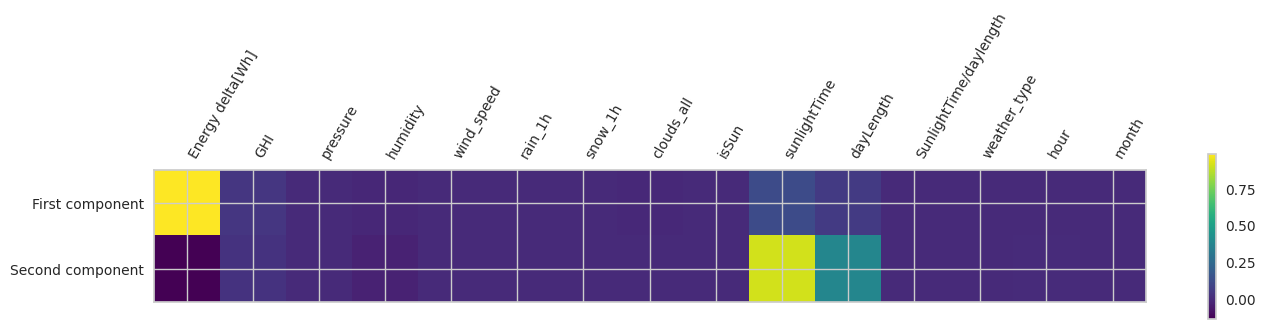

In [91]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(X.columns)), X.columns, rotation = 60, ha = 'left')
plt.show()

In [92]:
# print best features by name and by most important to least important
print(f"Best features by name: {X.columns[np.argsort(pca.components_[0])][::-1]}\n")
print(f"Best features by importance: {np.sort(pca.components_[0])[::-1]}\n")

Best features by name: Index(['Energy delta[Wh]', 'sunlightTime', 'dayLength', 'GHI', 'pressure',
       'isSun', 'SunlightTime/daylength', 'wind_speed', 'snow_1h', 'rain_1h',
       'month', 'weather_type', 'hour', 'clouds_all', 'humidity'],
      dtype='object')

Best features by importance: [ 9.90042056e-01  1.20825669e-01  5.50620343e-02  4.55248472e-02
  1.03650257e-03  2.57790717e-04  1.33521632e-04  4.90666024e-05
 -3.46263778e-06 -1.49507663e-05 -1.60971022e-04 -2.06889219e-04
 -4.91755329e-04 -6.61923335e-03 -8.26194848e-03]



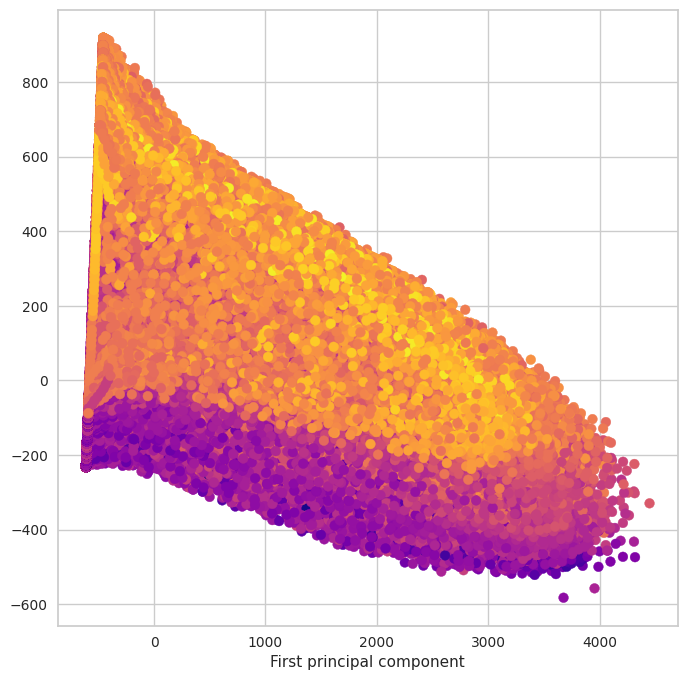

In [93]:
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='plasma')
plt.xlabel('First principal component')
plt.show()

In [94]:
viz = ValidationCurve(
        RandomForestRegressor(random_state = 1), 
        param_name = "max_leaf_nodes",
        param_range = [10**x + 1 for x in range(1, 5)], 
        cv = 5, scoring = "r2",
        logx = True,
        n_jobs = 4
      )

ValidationCurve(ax=<Axes: >, cv=5,
                estimator=RandomForestRegressor(random_state=1), logx=True,
                n_jobs=4, param_name='max_leaf_nodes',
                param_range=array([   11,   101,  1001, 10001]), scoring='r2')

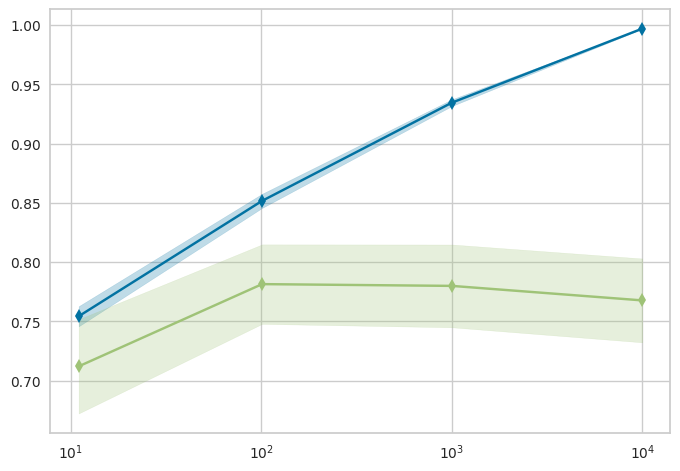

In [95]:
viz.fit(X, y)

In [51]:
neural_net = tf.keras.Sequential([
                layers.Dense(128, activation = 'relu'),
                layers.Dense(8),
                layers.Dense(8),
                layers.Dense(1)
             ])

In [52]:
neural_net.compile(optimizer = 'adam',
                   loss = 'mse',
                   metrics = ['mean_absolute_error']
                  )

In [16]:
scaler = StandardScaler().fit(train_X)

train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [64]:
history = neural_net.fit(train_X_scaled, 
                         train_y, 
                         validation_data = (test_X_scaled, test_y),
                         epochs = 14)

Epoch 1/14
2460/2460 [==============================] - 10s 4ms/step - loss: 9.0093 - mean_absolute_error: 2.3193 - val_loss: 9.0183 - val_mean_absolute_error: 2.3217
Epoch 2/14
2460/2460 [==============================] - 10s 4ms/step - loss: 8.9265 - mean_absolute_error: 2.3106 - val_loss: 8.8765 - val_mean_absolute_error: 2.2972
Epoch 3/14
2460/2460 [==============================] - 10s 4ms/step - loss: 8.8663 - mean_absolute_error: 2.3018 - val_loss: 8.8020 - val_mean_absolute_error: 2.2981
Epoch 4/14
2460/2460 [==============================] - 10s 4ms/step - loss: 8.8323 - mean_absolute_error: 2.2966 - val_loss: 8.7399 - val_mean_absolute_error: 2.2767
Epoch 5/14
2460/2460 [==============================] - 10s 4ms/step - loss: 8.7814 - mean_absolute_error: 2.2925 - val_loss: 8.8438 - val_mean_absolute_error: 2.3023
Epoch 6/14
2460/2460 [==============================] - 10s 4ms/step - loss: 8.7477 - mean_absolute_error: 2.2867 - val_loss: 8.8310 - val_mean_absolute_error: 2.293

In [65]:
predict_train_y = neural_net.predict(train_X_scaled) 
predict_y = neural_net.predict(test_X_scaled)

print(f"Neural Network train r2 score = {r2_score(predict_train_y, train_y)}")
print(f"Neural Network test r2 score = {r2_score(predict_y, test_y)}")

3690/3690 [==============================] - 5s 1ms/step
Neural Network train r2 score = 0.8475100544519356
Neural Network test r2 score = 0.8431283672228093


In [66]:
history_df = pd.DataFrame(history.history)

display(history_df.head())

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,9.009336,2.319262,9.018331,2.321656
1,8.926522,2.310646,8.876472,2.297227
2,8.866311,2.301780,8.801997,2.298064
3,8.832261,2.296614,8.739926,2.276741
4,8.781444,2.292521,8.843824,2.302278


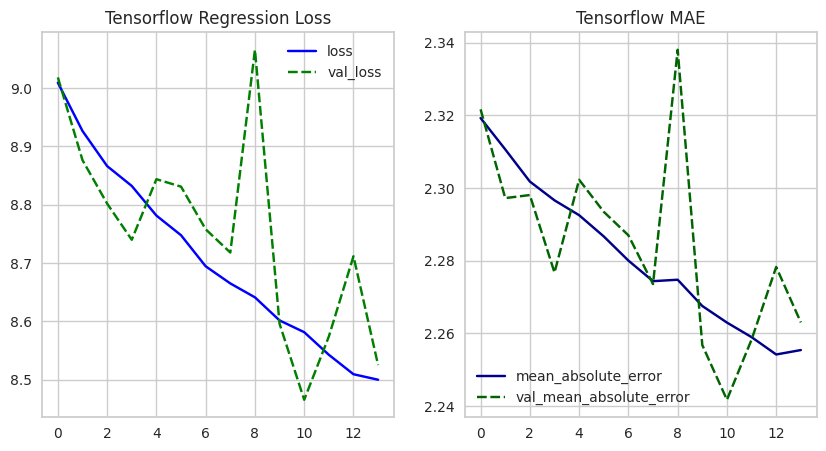

In [68]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.lineplot(history_df.loc[:, ['loss', 'val_loss']], 
             ax = axes[0], 
             palette = ['Blue', 'Green']
            ).set(title = "Tensorflow Regression Loss")

sns.lineplot(history_df.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']], 
             ax = axes[1], 
             palette = ['DarkBlue', 'DarkGreen']
            ).set(title = "Tensorflow MAE")


plt.show()

In [73]:
xgbr = Pipeline([
        ('scaler', StandardScaler()),
        ('xgbr', XGBRegressor(random_state = 1,
                              n_estimators = 200, 
                              learning_rate = 0.1,
                              base_score = 0.5
                             ))
        ])

xgbr.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbr',
                 XGBRegressor(base_score=0.5, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=1, ...))])

In [74]:
print(f"XGBoost train r2 score = {xgbr.score(train_X, train_y)}")
print(f"XGBoost test r2 score = {xgbr.score(test_X, test_y)}")

XGBoost train r2 score = 0.9143454521615716
XGBoost test r2 score = 0.9059562649877124


In [97]:
xgbr_scores = cross_val_score(
                Pipeline([
                    ('scaler', StandardScaler()),
                    ('xgbr', XGBRegressor(random_state = 1,
                                          n_estimators = 200, 
                                          learning_rate = 0.1,
                                          base_score = 0.5
                                         ))
                ]), X, y, cv = 5, n_jobs = 2
              )

In [98]:
print(f"Cross val scores for XGBoost = {xgbr_scores}")
print(f"Mean cross val scores = {xgbr_scores.mean()}")
print(f"Cross val scores standard deviation = {xgbr_scores.std()}")

Cross val scores for XGBoost = [0.83538042 0.75971684 0.76806348 0.82615629 0.83790243]
Mean cross val scores = 0.8054438895898197
Cross val scores standard deviation = 0.03425496917039167
